# Credit Card Fraud Detection

see: https://www.kaggle.com/mlg-ulb/creditcardfraud

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.


In [0]:
import random
import bisect
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, classification_report, fbeta_score, accuracy_score
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
import xgboost as xgb
import hyperopt
import tensorflow as tf


plt.rcParams.update({'font.size': 16})
PATH_DATA = '/kaggle/input/creditcardfraud/creditcard.csv'

Using TensorFlow backend.


## Exploratory Data Analysis

In [0]:
df_source = pd.read_csv(PATH_DATA)

In [0]:
normal_count, fraud_count = df_source['Class'].value_counts()
total_count = normal_count + fraud_count
print('Normal Count = {} ({:.2f} %)'.format(normal_count, normal_count * 100 / total_count))
print('Fraud Count = {} ({:.2f} %)'.format(fraud_count, fraud_count * 100 / total_count))
print('Total Count = ', total_count)

Normal Count = 284315 (99.83 %)
Fraud Count = 492 (0.17 %)
Total Count =  284807


Dataset的分布相當的不平衡

In [0]:
df_source

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [0]:
df_source.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


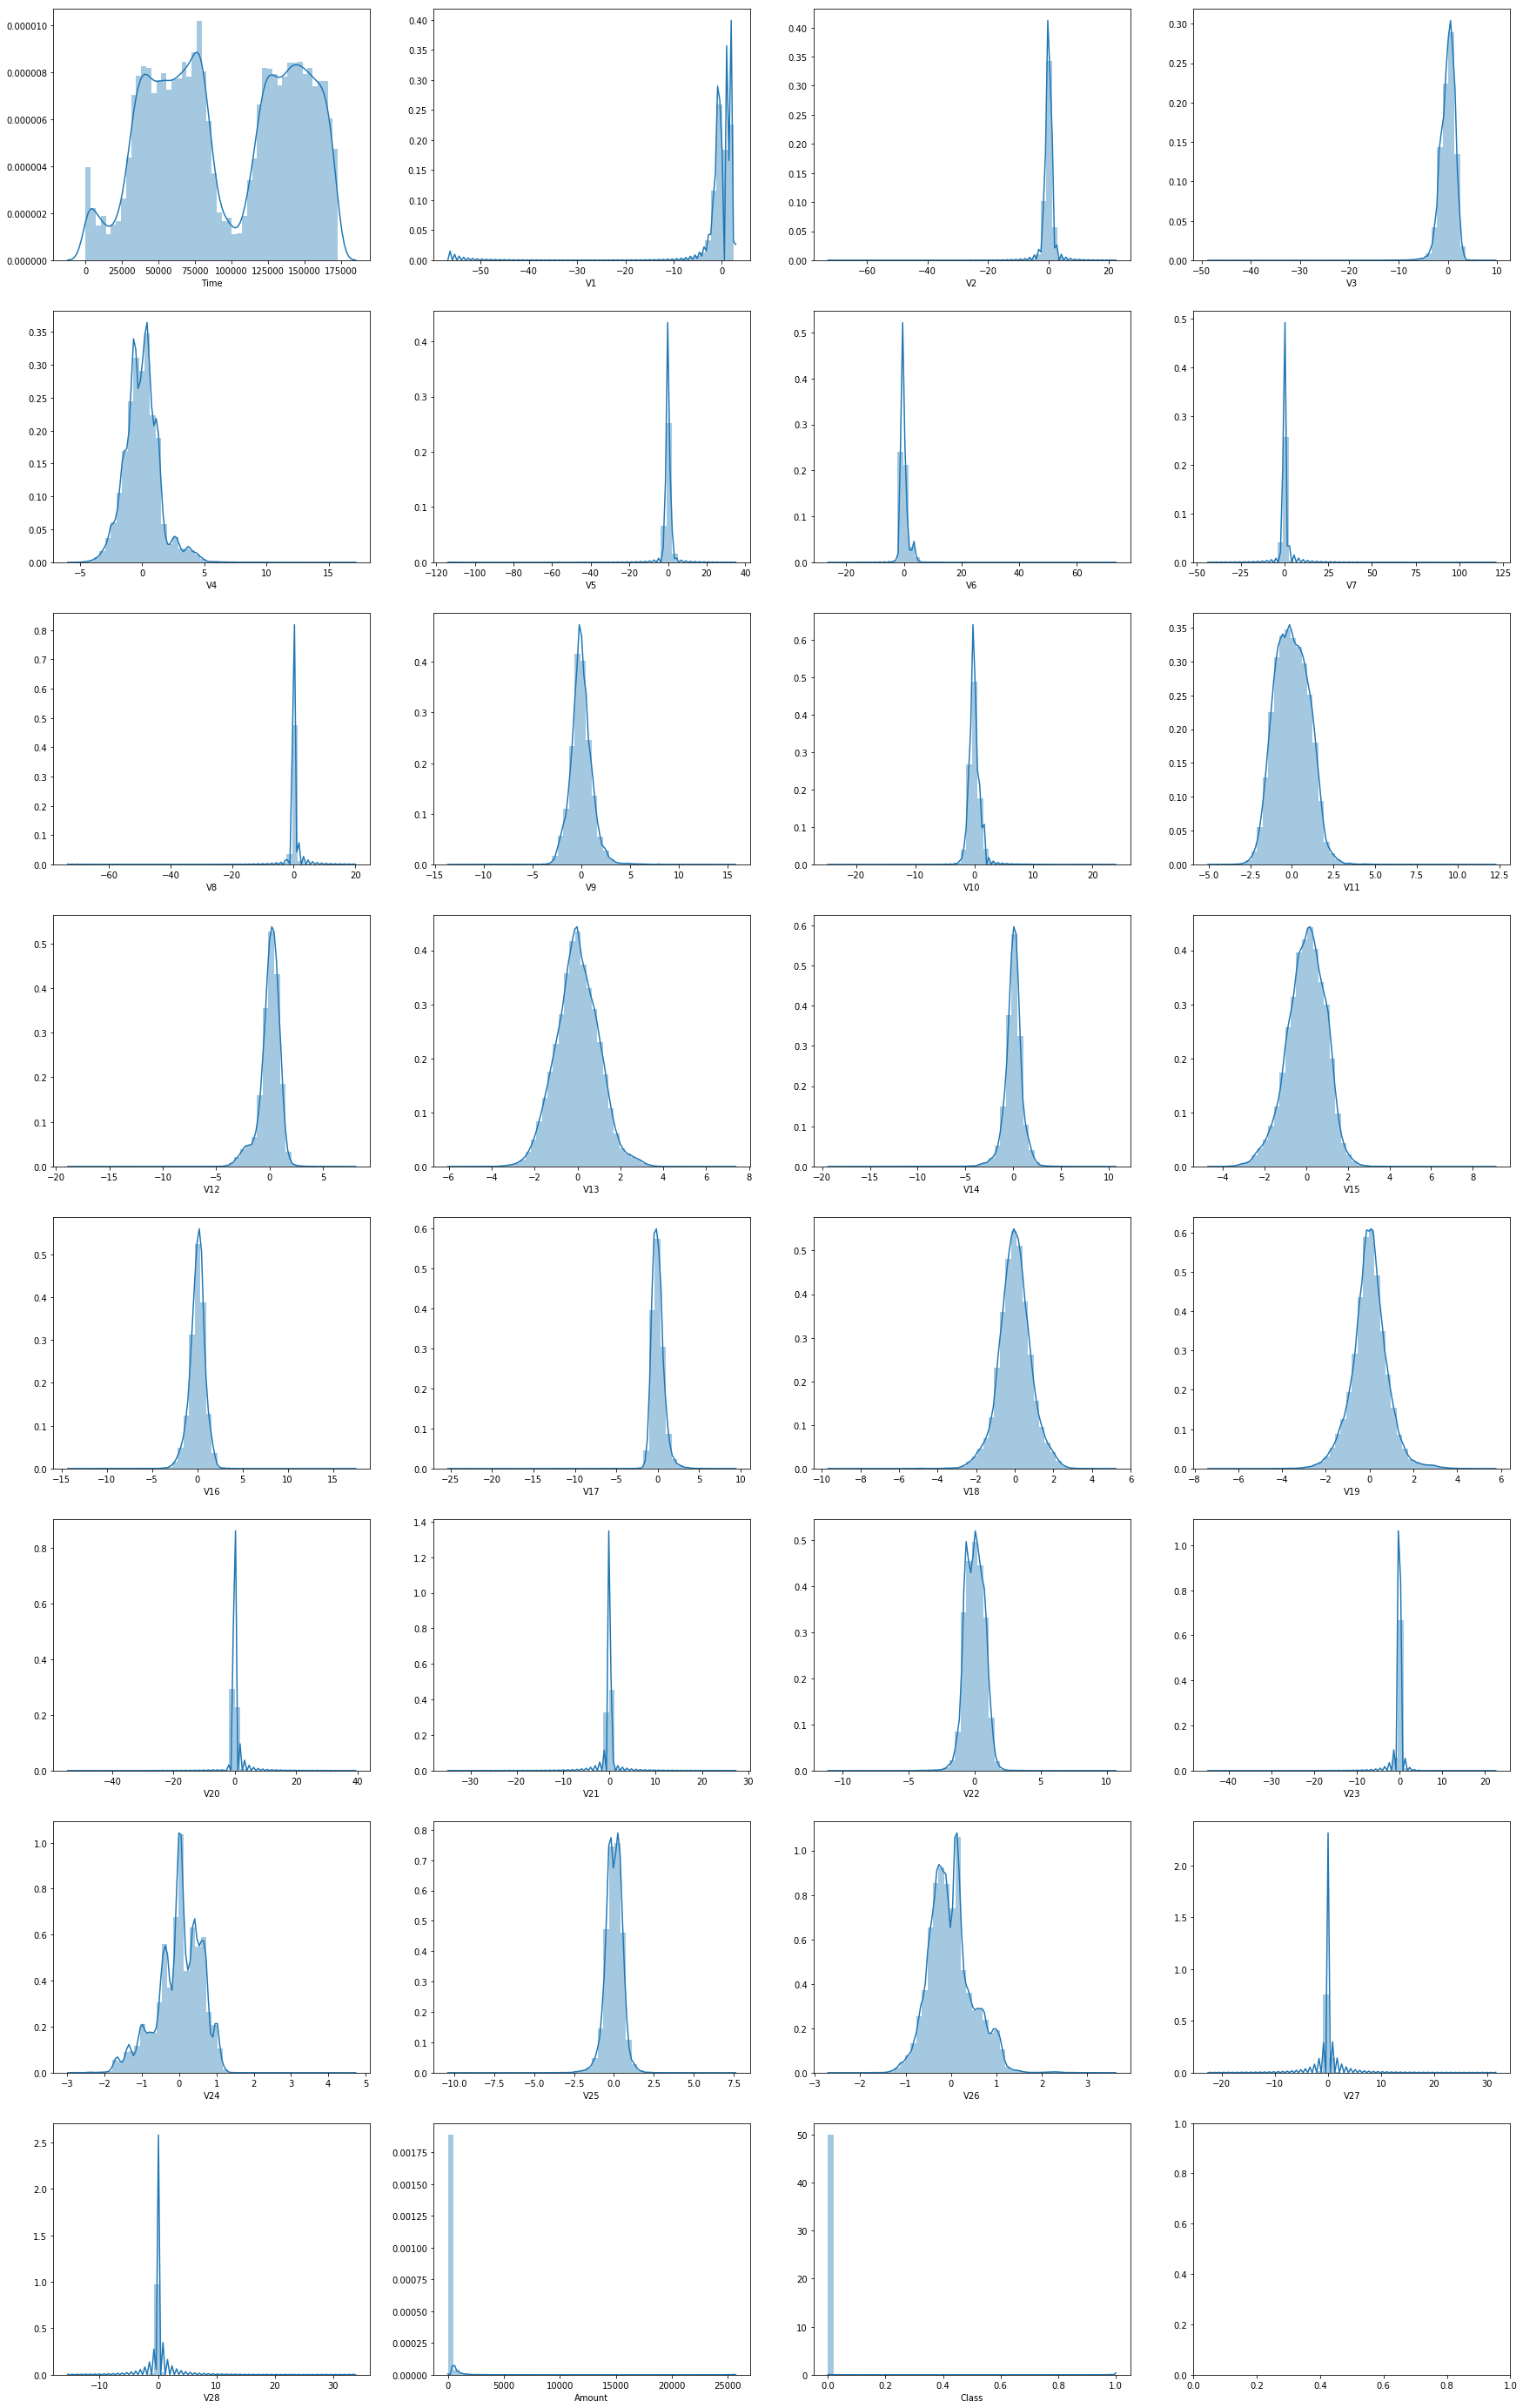

In [0]:
def plot_distribution(df):
    ncols = 4
    columns = df.columns
    nrows = int(np.ceil(len(columns) / ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30, 50))
    for i, column in enumerate(columns):
        sns.distplot(df_source[column],ax=axes[i//ncols, i%ncols])

plot_distribution(df_source)

* 其中Column `Amount` 有skew的情況且全為正數，所以會採用log1p轉換
* 所有feature會做一遍Standard Scaler
* 在拆分train/validation時要注意fraud data有沒有依比例的分配，因為fraud data實在太稀少了，不容許配置差異太大
* 因為fraud data只有大約400多筆，因此為了使的validation具有足夠的有效性，所以這裡採用50/50分配

In [0]:
class DatasetLoaderConfig:
    TRANSFORMS = [
        'log1p__Amount',
        'drop__Time',
        'standard_scalar',
    ]
    LABEL_COL = 'Class'

    def __init__(self):
        self._tape_record = {}
        self._is_read_mode = False
    
    @property
    def is_read_mode(self):
        return self._is_read_mode
    
    @is_read_mode.setter
    def is_read_mode(self, value):
        self._is_read_mode = value

    def get_tape_record(self, transform):
        assert self._is_read_mode is True
        return self._tape_record.get(transform)
    
    def set_tape_record(self, transform, record):
        assert self._is_read_mode is False
        self._tape_record[transform] = record


config = DatasetLoaderConfig()

In [0]:
class DatasetLoader:
    def __init__(self, config):
        self.dataset = None
        self.cfg = config
        self.label_col = 'Class'

    def load(self, filename):
        # Load the csv file
        self.dataset = pd.read_csv(filename)

        is_read_mode = self.cfg.is_read_mode

        # Transform
        for transform in self.cfg.TRANSFORMS:
            print('process: ', transform)
            operator, col = transform.split('__') if '__' in transform else (None, None)

            if operator == 'log1p':
                assert not any(self.dataset[col] < 0.0)
                self.dataset[col] = np.log(self.dataset[col] + 1.0)
            
            elif operator == 'drop':
                self.dataset.drop(labels=col, axis=1, inplace=True)

            elif transform == 'standard_scalar':
                exclude_cols = [self.cfg.LABEL_COL]
                if is_read_mode:
                    record = self.cfg.get_tape_record('standard_scalar')
                else:
                    record = {}
                    for col in self.dataset.columns:
                        if col in exclude_cols:
                            continue
                        scalar = preprocessing.StandardScaler().fit(
                            self.dataset[[col]].astype(np.float64))
                        record[col] = scalar
                    self.cfg.set_tape_record('standard_scalar', record)

                for col in self.dataset.columns:
                    if col in exclude_cols:
                        continue
                    self.dataset[col] = record[col].transform(
                        self.dataset[[col]].astype(np.float64))

            else:
                raise NotImplementedError('{} is not a valid transform.'.format(transform))

    def split_by_index(self, train_index, valid_index):
        train_dataset = DatasetLoader(self.cfg)
        train_dataset.dataset = pd.DataFrame(self.dataset, index=train_index)

        val_dataset = DatasetLoader(self.cfg)
        val_dataset.dataset = pd.DataFrame(self.dataset, index=valid_index)

        return train_dataset, val_dataset

    def get_feature(self):
        feature = self.dataset.copy()
        if self.cfg.LABEL_COL in feature.columns:
            feature.drop(self.cfg.LABEL_COL, axis=1, inplace=True)
        feature.astype(np.float32)
        feature = feature.reindex(sorted(feature.columns), axis=1)
        return feature.values

    def get_label(self):
        return self.dataset[self.cfg.LABEL_COL].values

    def save(self, filename):
        self.dataset.to_csv(filename)

    def __getitem__(self, key):
        dsl = DatasetLoader(self.cfg)
        dsl.dataset = self.dataset.loc[key, :]
        return dsl
    
    def __len__(self):
        return self.dataset.shape[0]

    
source_loader = DatasetLoader(config)
source_loader.load(PATH_DATA)

valid_ratio = 0.5
count_source_loader = len(source_loader)
cutoff_idx = int(count_source_loader * 0.5)
idx_list = list(range(count_source_loader))
random.shuffle(idx_list)

train_loader, valid_loader = source_loader.split_by_index(idx_list[cutoff_idx:], idx_list[:cutoff_idx])

process:  log1p__Amount
process:  drop__Time
process:  standard_scalar


In [0]:
_, (train_normal_count, train_fraud_count) = np.unique(train_loader.get_label(), return_counts=True)
_, (valid_normal_count, valid_fraud_count) = np.unique(valid_loader.get_label(), return_counts=True)
print('Training Part: Fraud Count = {}, Normal Count = {}'.format(train_fraud_count, train_normal_count))
print('Validation Part:  Fraud Count = {}, Normal Count = {}'.format(valid_fraud_count, valid_normal_count))

Training Part: Fraud Count = 254, Normal Count = 142150
Validation Part:  Fraud Count = 238, Normal Count = 142165


仔細檢查Fault Count有沒有平均分配？有的　　

再來看看分布情況

In [0]:
source_loader.dataset.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,-8.157366e-16,3.154853e-17,-4.409878e-15,-6.734811e-16,-2.874435e-16,4.168992e-16,-8.767997e-16,-2.423604e-16,3.078727e-16,2.026926e-17,...,1.685077e-17,1.478472e-15,-6.797197e-16,1.234659e-16,-7.659279e-16,3.247603e-16,-2.953495e-18,5.401572e-17,-1.059066e-14,0.001727
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,0.041527
min,-2.879855e+01,-4.403529e+01,-3.187173e+01,-4.013919e+00,-8.240810e+01,-1.963606e+01,-3.520940e+01,-6.130252e+01,-1.222802e+01,-2.258191e+01,...,-4.741907e+01,-1.506565e+01,-7.175446e+01,-4.683638e+00,-1.975033e+01,-5.401098e+00,-5.590660e+01,-4.674612e+01,-1.902754e+00,0.000000
25%,-4.698918e-01,-3.624707e-01,-5.872142e-01,-5.993788e-01,-5.010686e-01,-5.766822e-01,-4.478860e-01,-1.746805e-01,-5.853631e-01,-4.917360e-01,...,-3.109433e-01,-7.473476e-01,-2.591784e-01,-5.854676e-01,-6.084001e-01,-6.780717e-01,-1.755053e-01,-1.604440e-01,-7.636627e-01,0.000000
50%,9.245351e-03,3.965683e-02,1.186124e-01,-1.401724e-02,-3.936682e-02,-2.058046e-01,3.241723e-02,1.871982e-02,-4.681169e-02,-8.533551e-02,...,-4.009429e-02,9.345377e-03,-1.792420e-02,6.765678e-02,3.183240e-02,-1.081217e-01,3.325174e-03,3.406368e-02,-1.007690e-02,0.000000
75%,6.716939e-01,4.867202e-01,6.774569e-01,5.250082e-01,4.433465e-01,2.991625e-01,4.611107e-01,2.740785e-01,5.435305e-01,4.168842e-01,...,2.537392e-01,7.283360e-01,2.364319e-01,7.257153e-01,6.728006e-01,4.996663e-01,2.255648e-01,2.371526e-01,7.283598e-01,0.000000
max,1.253351e+00,1.335775e+01,6.187993e+00,1.191874e+01,2.521413e+01,5.502015e+01,9.747824e+01,1.675153e+01,1.419494e+01,2.180758e+01,...,3.703471e+01,1.447304e+01,3.607668e+01,7.569684e+00,1.442532e+01,7.293975e+00,7.831940e+01,1.025434e+02,4.226464e+00,1.000000


對半切出training和validation set

In [0]:
x_train = train_loader.get_feature()
y_train = train_loader.get_label()
x_valid = valid_loader.get_feature()
y_valid = valid_loader.get_label()

## Train: Under-Sampling or Over-Sampling

雖然我們知道資料不平衡，但是我們先不對它作特別處理，直接用xgboost硬train一波，當作我們的baseline

In [0]:
def get_auprc(model, x, y):
    prob_y = model.predict_proba(x)[:, 1]
    true_y = y
    precision, recall, _ = precision_recall_curve(true_y, prob_y)
    auprc = auc(recall, precision)
    return auprc


def get_best_model(x_train, y_train, x_valid, y_valid, fit_model, searching_space):
    def objective(arg_dict):
        model = fit_model(x_train, y_train, arg_dict)
        auprc = get_auprc(model, x_valid, y_valid)
        return -1 * auprc

    algo = hyperopt.tpe.suggest
    best_param = hyperopt.fmin(objective, searching_space, algo=algo, max_evals=30)
    
    model = fit_model(x_train, y_train, best_param)
    return model

In [0]:
xgb_searching_space = {
    'n_estimators': hyperopt.hp.quniform('n_estimators', 2000, 10000, 2000),
    'max_depth': hyperopt.hp.quniform('max_depth', 5, 21, 2),
    'subsample': hyperopt.hp.quniform('subsample', 0.7, 1.0, 0.1),
    'colsample_bytree': hyperopt.hp.quniform('colsample_bytree', 0.7, 1.0, 0.1),
}

In [0]:
def summary_in_this_game(model, x, y):
    true_y = y
    pred_y = model.predict(x)
    content = '=' * 40 + '\n'
    content += classification_report(true_y, pred_y, digits=5) + '\n'
    f2 = fbeta_score(true_y, pred_y, beta=2)
    content += 'f2 score = {:.5f}\n'.format(f2)
    acc = accuracy_score(true_y, pred_y)
    content += 'accuracy = {:.5f}\n'.format(acc)
    content += '=' * 40 + '\n'
    print(content)

In [0]:
def fit_model_baseline(x, y, arg_dict):
    params = dict(
        learning_rate=0.05,
        min_child_weight=1,
        gamma=0,
        scale_pos_weight=1,
        seed=27,
        tree_method='gpu_hist',
        n_estimators=int(arg_dict['n_estimators']),
        max_depth=int(arg_dict['max_depth']),
        subsample=arg_dict['subsample'],
        colsample_bytree=arg_dict['colsample_bytree']
    )
    model = xgb.XGBClassifier(**params)
    model.fit(x, y)
    return model


model_baseline = get_best_model(x_train, y_train, x_valid, y_valid, fit_model_baseline, xgb_searching_space)
summary_in_this_game(model_baseline, x_valid, y_valid)

100%|██████████| 30/30 [09:54<00:00, 19.81s/it, best loss: -0.8442101336496463]
              precision    recall  f1-score   support

           0    0.99968   0.99988   0.99978    142165
           1    0.91866   0.80672   0.85906       238

    accuracy                        0.99956    142403
   macro avg    0.95917   0.90330   0.92942    142403
weighted avg    0.99954   0.99956   0.99954    142403

f2 score = 0.82687
accuracy = 0.99956



使得數據集平衡的方法有下面幾種：
* Sample Weight
* SMOTE (Synthetic Minority Oversampling Technique)
* NearMiss

### Sample Weight

給予數據類別權重，這等同於對數據作sampling

In [0]:
def fit_model_sample_weight(x, y, arg_dict):
    params = dict(
        learning_rate=0.05,
        min_child_weight=1,
        gamma=0,
        scale_pos_weight=1,
        seed=27,
        tree_method='gpu_hist',
        n_estimators=int(arg_dict['n_estimators']),
        max_depth=int(arg_dict['max_depth']),
        subsample=arg_dict['subsample'],
        colsample_bytree=arg_dict['colsample_bytree']
    )
    model = xgb.XGBClassifier(**params)
    sample_weight = np.where(y == 0, 0.02, 0.98)
    model.fit(x, y, sample_weight=sample_weight)
    return model


model_sample_weight = get_best_model(x_train, y_train, x_valid, y_valid, fit_model_sample_weight, xgb_searching_space)
summary_in_this_game(model_sample_weight, x_valid, y_valid)

100%|██████████| 30/30 [12:33<00:00, 25.12s/it, best loss: -0.8433164853527134]
              precision    recall  f1-score   support

           0    0.99973   0.99966   0.99970    142165
           1    0.80645   0.84034   0.82305       238

    accuracy                        0.99940    142403
   macro avg    0.90309   0.92000   0.91137    142403
weighted avg    0.99941   0.99940   0.99940    142403

f2 score = 0.83333
accuracy = 0.99940



### SMOTE (Synthetic Minority Oversampling Technique)

從既有的Fraud Data當中，使用k-nearest neighbors，產生相似的合成Fraud Data

In [0]:
def fit_model_smote(x, y, arg_dict):
    sm = SMOTE(random_state=42)
    x_res, y_res = sm.fit_resample(x, y)

    params = dict(
        learning_rate=0.05,
        min_child_weight=1,
        gamma=0,
        scale_pos_weight=1,
        seed=27,
        tree_method='gpu_hist',
        n_estimators=int(arg_dict['n_estimators']),
        max_depth=int(arg_dict['max_depth']),
        subsample=arg_dict['subsample'],
        colsample_bytree=arg_dict['colsample_bytree']
    )
    model = xgb.XGBClassifier(**params)
    model.fit(x_res, y_res)
    return model


model_smote = get_best_model(x_train, y_train, x_valid, y_valid, fit_model_smote, xgb_searching_space)
summary_in_this_game(model_smote, x_valid, y_valid)

100%|██████████| 30/30 [19:25<00:00, 38.84s/it, best loss: -0.8459824776585668]
              precision    recall  f1-score   support

           0    0.99972   0.99972   0.99972    142165
           1    0.83193   0.83193   0.83193       238

    accuracy                        0.99944    142403
   macro avg    0.91583   0.91583   0.91583    142403
weighted avg    0.99944   0.99944   0.99944    142403

f2 score = 0.83193
accuracy = 0.99944



### NearMiss

使用k-nearest neighbors的方法來界定出Normal/Fraud邊界，再刪除邊界上的Normal Data

In [0]:
def fit_model_nm(x, y, arg_dict):
    nm = NearMiss()
    x_res, y_res = nm.fit_resample(x, y)

    params = dict(
        learning_rate=0.05,
        min_child_weight=1,
        gamma=0,
        scale_pos_weight=1,
        seed=27,
        tree_method='gpu_hist',
        n_estimators=int(arg_dict['n_estimators']),
        max_depth=int(arg_dict['max_depth']),
        subsample=arg_dict['subsample'],
        colsample_bytree=arg_dict['colsample_bytree']
    )
    model = xgb.XGBClassifier(**params)
    model.fit(x_res, y_res)
    return model


model_nm = get_best_model(x_train, y_train, x_valid, y_valid, fit_model_nm, xgb_searching_space)
summary_in_this_game(model_nm, x_valid, y_valid)

100%|██████████| 30/30 [08:43<00:00, 17.45s/it, best loss: -0.5444572786528881]
              precision    recall  f1-score   support

           0    0.99960   0.21344   0.35177    142165
           1    0.00202   0.94958   0.00403       238

    accuracy                        0.21467    142403
   macro avg    0.50081   0.58151   0.17790    142403
weighted avg    0.99794   0.21467   0.35119    142403

f2 score = 0.01000
accuracy = 0.21467



###  Precision Recall Curve on Classification Models

因為有每一預測點的probability，所以我們可以來看model整體的健康度，且因為資料集不平衡，觀察accuracy或AUC都沒有太大意義，所以我們看的指標是AUPRC (Area under Precision Recall Curve)，如下所示

In [0]:
def plot_precision_recall_curve(models):
    plt.figure(figsize=(20,12))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    for i, (name, model) in enumerate(models.items()):
        color = plt.get_cmap('Set1').colors[i]

        prob_y = model.predict_proba(x_valid)[:, 1]
        true_y = y_valid

        precision, recall, thresholds = precision_recall_curve(true_y, prob_y)
        auprc = auc(recall, precision)

        index = bisect.bisect_left(list(thresholds), 0.5)

        plt.plot(recall, precision, color=color, label='{} (auprc={:.4f})'.format(name, auprc))
        plt.axvline(x=recall[index], color=color, linestyle='--', label='{}@threshold=0.5'.format(name))
        plt.axhline(y=precision[index], color=color, linestyle='--')

    plt.legend()
    plt.show()

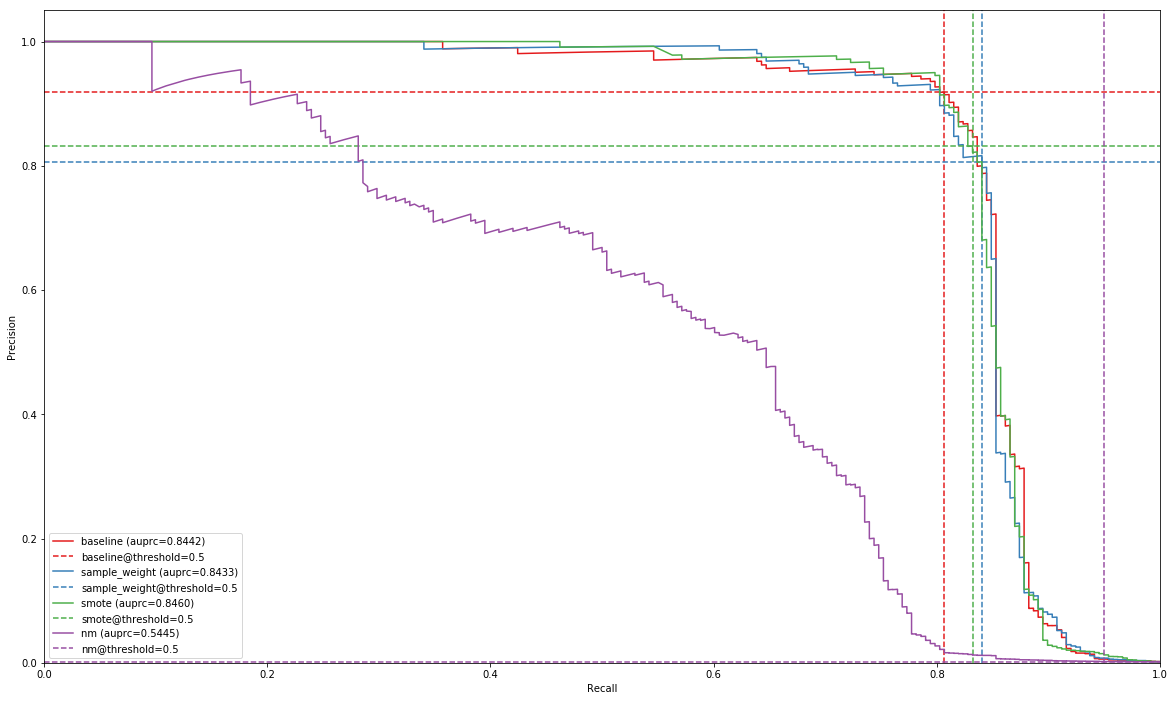

In [0]:
models = {
    'baseline': model_baseline,
    'sample_weight': model_sample_weight,
    'smote': model_smote,
    'nm': model_nm,
}

plot_precision_recall_curve(models)

由上圖可以看出，在這個例子當中，對數據不平衡作特別處理顯然沒有吃到太多甜頭，甚至處理不好還會使Model歪掉。

## Train: Semi-Supervised Anomaly Detection

剛剛我們的觀點是做分類問題，想辦法將Normal和Fraud給區分開來，但是因為遭受imbalance所苦，所以我們必須要想辦法讓Model可以學到Fraud的特徵，因此做了很多嘗試和努力。

接下來我們來嘗試不同觀點，假設今天我們直接拿Normal的數據，然後讓Model學習Normal的情況，並且劃分出界線，超出界線的就是異常，也就可能是Fraud，這樣的觀點稱為Anomaly Detection。

先來觀察一下原始數據的分布情況

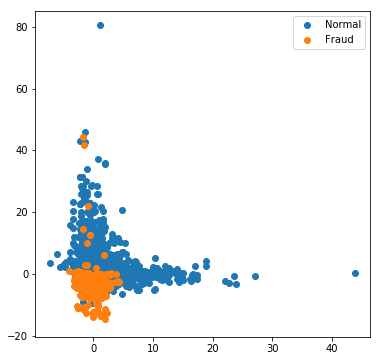

In [0]:
x = x_train
y = y_train

pca = PCA(n_components=2)
x_reduced = pca.fit_transform(x)
plt.figure(figsize=(6,6))
plt.scatter(x_reduced[y == 0, 0], x_reduced[y == 0, 1], label='Normal')
plt.scatter(x_reduced[y == 1, 0], x_reduced[y == 1, 1], label='Fraud')
plt.legend()
plt.show()

Normal和Fraud的資料全都糾結在一起，我們目標是想辦法讓Model去學習Normal的資料，然後有利於我們轉到更好描述Normal的空間，此時如果一筆Fraud的資料進來，它應該會偏離Normal的資料集合，這一筆Fraud附近的密度應該會比較稀疏。

以下會嘗試以下幾種的Anomaly Detection
* Gaussian Based
* Support Vector Machines Based - One Class SVM
* Tree Based - Isolation Forest
* Neural Based - Autoencoder

### Gaussian Based

首先，我們不考慮任何轉換，我們在既有的feature space上計算哪些點的資料密度相對低，藉此來判斷是否為異常點。

最簡單的作法是使用數據集去擬合「一個」高斯分布，並且決定一個密度下界，如果密度低於下界的點位就認為是異常值，所以未來新的一筆資料進來，我就可以看看在這個分布下，這個點的密度，在藉由密度下界去判定他是不是異常的。

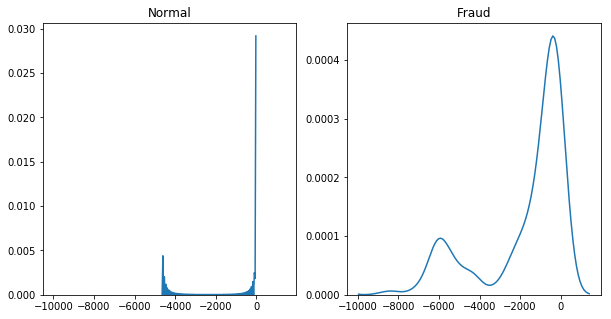

In [0]:
from scipy.stats import multivariate_normal
x_train_normal = x_train[y_train==0, :]
x_train_fraud = x_train[y_train==1, :]

mu = x_train_normal.mean(axis=0)
sigma = np.cov(x_train_normal.T)
single_gaussian = multivariate_normal(cov=sigma, mean=mu, allow_singular=True)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

axes[0].set_title('Normal')
sns.distplot(single_gaussian.logpdf(x_train_normal), kde=True, hist=False, ax=axes[0])
axes[1].set_title('Fraud')
sns.distplot(single_gaussian.logpdf(x_train_fraud), kde=True, hist=False, ax=axes[1])
plt.show()

上面的方法是用「一個」高斯分布來描述，但是如果其原本的分布沒有那麼均勻，我們就會想使用「多個」高斯分布來擬合，此時我們使用 `GaussianMixture` 來做到這件事。

我們先把 `GaussianMixture` 的 `n_components` 數量調成 1 ，看看有沒有看上面的結果一模一樣

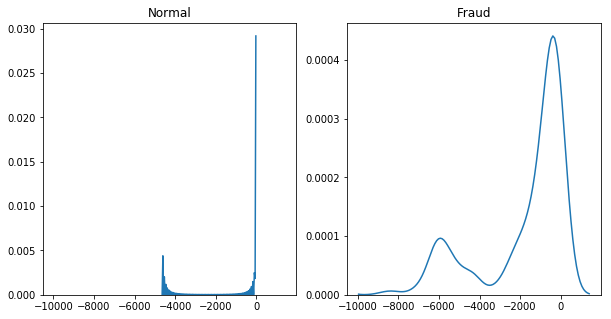

In [0]:
x_train_normal = x_train[y_train==0, :]
x_train_fraud = x_train[y_train==1, :]

gmm = GaussianMixture(n_components=1, n_init=4, random_state=42)
gmm.fit(x_train_normal)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

axes[0].set_title('Normal')
sns.distplot(gmm.score_samples(x_train_normal), kde=True, hist=False, ax=axes[0])
axes[1].set_title('Fraud')
sns.distplot(gmm.score_samples(x_train_fraud), kde=True, hist=False, ax=axes[1])
plt.show()

沒有疑慮，的確是一樣的，這樣接下來我們就可以放心的用多個高斯分布去擬合。

先定義待會會一直用到的 `get_best_threshold_by_f2` ，我們將挑選threshold的目標定在優化F2-Score，相比於F1-Score，F2-Score更看中recall之於precision。

In [0]:
def get_best_threshold_by_f2(true_y, scores):
    best_f2 = 0.0
    best_threshold = None

    max_score = np.max(scores)
    min_score = np.min(scores)
    step_size = (max_score - min_score)/1000
    thresholds = np.arange(min_score, max_score, step_size)
    for threshold in list(thresholds):
        pred_y = (scores < threshold).astype(float)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            f2 = fbeta_score(true_y, pred_y, beta=2)
        if f2 > best_f2:
            best_f2 = f2
            best_threshold = threshold
    return best_threshold

In [0]:
class GaussianBasedAnomalyDetection:
    def __init__(self, n_components):
        self.gaussian_mixture = GaussianMixture(n_components=n_components, n_init=4, random_state=42)
        self.threshold = None
    
    def fit(self, x, y):
        x_normal = x[y==0, :]
        self.gaussian_mixture.fit(x_normal)
        
        scores = self.gaussian_mixture.score_samples(x)
        self.threshold = get_best_threshold_by_f2(y, scores)
    
    def predict(self, x):
        scores = self.gaussian_mixture.score_samples(x)
        fraud = (scores < self.threshold).astype(float)
        return fraud


history = {}
for n_components in [1, 2, 3, 4, 5, 6, 7, 8]:
    model = GaussianBasedAnomalyDetection(n_components)
    model.fit(x_train, y_train)
    f2 = fbeta_score(y_valid, model.predict(x_valid), beta=2)
    print('n_components={}: f2={:.5f}'.format(n_components, f2))
    history[n_components] = (f2, model)

model_gaussian = sorted(history.values(), key=lambda x: x[0])[-1][1]
summary_in_this_game(model_gaussian, x_valid, y_valid)

n_components=1: f2=0.59957
n_components=2: f2=0.61123
n_components=3: f2=0.32364
n_components=4: f2=0.72405
n_components=5: f2=0.72574
n_components=6: f2=0.41899
n_components=7: f2=0.53558
n_components=8: f2=0.21934
              precision    recall  f1-score   support

           0    0.99960   0.99920   0.99940    142165
           1    0.61356   0.76050   0.67917       238

    accuracy                        0.99880    142403
   macro avg    0.80658   0.87985   0.83929    142403
weighted avg    0.99895   0.99880   0.99886    142403

f2 score = 0.72574
accuracy = 0.99880



### Support Vector Machines Based - One Class SVM


In [0]:
class SVMAnomalyDetection:
    def __init__(self):
        self.svm = OneClassSVM(kernel='rbf', nu=0.0005, gamma=0.007)  # auto gamma=0.034482758620689655
        self.threshold = None
    
    def fit(self, x, y):
        x_normal = x[y==0, :]
        self.svm.fit(x_normal)
        
        distances = self.svm.decision_function(x)
        self.threshold = get_best_threshold_by_f2(y, distances)
    
    def predict(self, x):
        distances = self.svm.decision_function(x)
        fraud = (distances < self.threshold).astype(float)
        return fraud


model_svm = SVMAnomalyDetection()
model_svm.fit(x_train, y_train)
summary_in_this_game(model_svm, x_valid, y_valid)

              precision    recall  f1-score   support

           0    0.99936   0.99763   0.99849    142165
           1    0.30372   0.61765   0.40720       238

    accuracy                        0.99699    142403
   macro avg    0.65154   0.80764   0.70285    142403
weighted avg    0.99820   0.99699   0.99751    142403

f2 score = 0.51184
accuracy = 0.99699



### Tree Based - Isolation Forest

In [0]:
class IsolationForestAnomalyDetection:
    def __init__(self):
        self.forest = IsolationForest(
            random_state=42, n_jobs=-1, contamination=0.1, behaviour='new', bootstrap=True, max_samples=1.0, n_estimators=500)
        self.threshold = None
    
    def fit(self, x, y):
        x_normal = x[y==0, :]
        self.forest.fit(x_normal)
        
        scores = self.forest.score_samples(x)
        self.threshold = get_best_threshold_by_f2(y, scores)
    
    def predict(self, x):
        scores = self.forest.score_samples(x)
        fraud = (scores < self.threshold).astype(float)
        return fraud


model_forest = IsolationForestAnomalyDetection()
model_forest.fit(x_train, y_train)
summary_in_this_game(model_forest, x_valid, y_valid)

              precision    recall  f1-score   support

           0    0.99936   0.99714   0.99825    142165
           1    0.26534   0.61765   0.37121       238

    accuracy                        0.99650    142403
   macro avg    0.63235   0.80739   0.68473    142403
weighted avg    0.99813   0.99650   0.99720    142403

f2 score = 0.48805
accuracy = 0.99650



### Neural Based - Autoencoder

我們使用Autoencoder去將Normal壓縮到一個latent space，然後希望這個latent space有辦法幫助我們區分開Fraud和Normal的Data，我們使用Linear的SVM來做最後的判定。

In [0]:
from sklearn.svm import LinearSVC


class AutoencoderAnomalyDetection:
    FEATURE_DIM = 29

    def __init__(self):
        n_hiddens = [100, 50]
        n_embedded = 25

        input_layer = tf.keras.layers.Input(shape=(self.FEATURE_DIM,))
        encoded = tf.keras.layers.Dense(n_hiddens[0], activation='tanh')(input_layer)
        encoded = tf.keras.layers.Dense(n_hiddens[1], activation='tanh')(encoded)
        encoded = tf.keras.layers.Dense(n_embedded)(encoded)

        decoded = tf.keras.layers.Dense(n_hiddens[-1], activation='tanh')(encoded)
        decoded = tf.keras.layers.Dense(n_hiddens[-2], activation='tanh')(decoded)
        decoded = tf.keras.layers.Dense(self.FEATURE_DIM)(decoded)

        autoencoder = tf.keras.models.Model(input_layer, decoded)
        encoder = tf.keras.models.Model(input_layer, encoded)
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.5)
        autoencoder.compile(optimizer='adadelta', loss='mse')

        self.autoencoder = autoencoder
        self.encoder = encoder
        self.threshold = None
    
    def fit(self, x, y):
        x_normal = x[y==0, :]
        self.autoencoder.fit(x_normal, x_normal, epochs=100, batch_size=256,
                             shuffle=True, verbose=2, validation_split=0.2)
        
        embedded_x = self.encoder.predict(x)
        svc = LinearSVC(class_weight='balanced').fit(embedded_x, y)
        self.svc = svc
    
    def predict(self, x):
        embedded_x = self.encoder.predict(x)
        fraud = self.svc.predict(embedded_x)
        return fraud


model_autoencoder = AutoencoderAnomalyDetection()
model_autoencoder.fit(x_train, y_train)

Train on 113728 samples, validate on 28432 samples
Epoch 1/100
113728/113728 - 2s - loss: 1.0642 - val_loss: 1.0166
Epoch 2/100
113728/113728 - 1s - loss: 1.0350 - val_loss: 0.9870
Epoch 3/100
113728/113728 - 1s - loss: 1.0055 - val_loss: 0.9580
Epoch 4/100
113728/113728 - 1s - loss: 0.9771 - val_loss: 0.9305
Epoch 5/100
113728/113728 - 1s - loss: 0.9504 - val_loss: 0.9047
Epoch 6/100
113728/113728 - 1s - loss: 0.9254 - val_loss: 0.8807
Epoch 7/100
113728/113728 - 1s - loss: 0.9022 - val_loss: 0.8584
Epoch 8/100
113728/113728 - 1s - loss: 0.8807 - val_loss: 0.8378
Epoch 9/100
113728/113728 - 1s - loss: 0.8608 - val_loss: 0.8187
Epoch 10/100
113728/113728 - 1s - loss: 0.8423 - val_loss: 0.8011
Epoch 11/100
113728/113728 - 1s - loss: 0.8252 - val_loss: 0.7847
Epoch 12/100
113728/113728 - 1s - loss: 0.8093 - val_loss: 0.7694
Epoch 13/100
113728/113728 - 1s - loss: 0.7945 - val_loss: 0.7551
Epoch 14/100
113728/113728 - 1s - loss: 0.7806 - val_loss: 0.7417
Epoch 15/100
113728/113728 - 1s - 

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [0]:
summary_in_this_game(model_autoencoder, x_valid, y_valid)

              precision    recall  f1-score   support

           0    0.99966   0.99720   0.99843    142155
           1    0.33445   0.80645   0.47281       248

    accuracy                        0.99687    142403
   macro avg    0.66705   0.90183   0.73562    142403
weighted avg    0.99850   0.99687   0.99751    142403

f2 score = 0.62893
accuracy = 0.99687



我們來看一下在latent space上，SVM切一刀的情況，如下

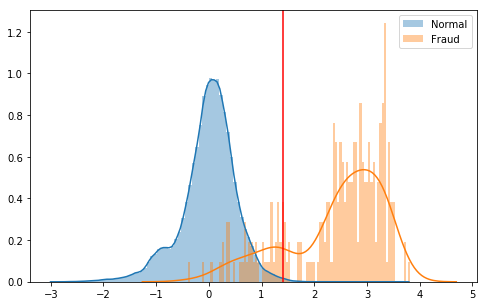

In [0]:
embedded_x = model_autoencoder.encoder.predict(x_valid)
proj_axis = model_autoencoder.svc.coef_[0]
threshold = -1 * model_autoencoder.svc.intercept_[0]
embedded_x_reduced = np.dot(embedded_x, proj_axis)

x_normal = embedded_x_reduced[y_valid==0]
x_fraud = embedded_x_reduced[y_valid==1]

fig, axes = plt.subplots(1, 1, figsize=(8, 5), sharex=True)
sns.distplot(x_normal, ax=axes, label='Normal', bins=100)
sns.distplot(x_fraud, ax=axes, label='Fraud', bins=100)
plt.axvline(x=threshold, color='red')
plt.legend()
plt.show()

## Summary

| Model Type        | Algorithm                                     | F2-Score |
|-------------------|-----------------------------------------------|----------|
| Classification    | baseline + xgboost                            | 0.82687  |
| Classification    | sample_weight + xgboost                       | 0.83333  |
| Classification    | SMOTE + xgboost                               | 0.83193  |
| Classification    | NearMiss + xgboost                            | 0.01000  |
| Anomaly Detection | Gaussian Based                                | 0.72574  |
| Anomaly Detection | Support Vector Machines Based - One Class SVM | 0.51184  |
| Anomaly Detection | Tree Based - Isolation Forest                 | 0.48805  |
| Anomaly Detection | Neural Based - Autoencoder + SVM              | 0.62893  |


## Reference

* https://www.geeksforgeeks.org/ml-handling-imbalanced-data-with-smote-and-near-miss-algorithm-in-python/
* https://www.kaggle.com/matheusfacure/semi-supervised-anomaly-detection-survey
